In [4]:
# Import library
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from haversine import haversine
# 1. Load Data
df = pd.read_csv("uber.csv")
# 2. Cek Missing Value
print("Missing Value per Kolom:")
print(df.isnull().sum())
# 3. Analisis Awal
print("\nStatistik Deskriptif:")
print(df.describe())

Missing Value per Kolom:
Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

Statistik Deskriptif:
         Unnamed: 0    fare_amount  pickup_longitude  pickup_latitude  \
count  2.000000e+05  200000.000000     200000.000000    200000.000000   
mean   2.771250e+07      11.359955        -72.527638        39.935885   
std    1.601382e+07       9.901776         11.437787         7.720539   
min    1.000000e+00     -52.000000      -1340.648410       -74.015515   
25%    1.382535e+07       6.000000        -73.992065        40.734796   
50%    2.774550e+07       8.500000        -73.981823        40.752592   
75%    4.155530e+07      12.500000        -73.967154        40.767158   
max    5.542357e+07     499.000000         57.418457      1644.421482   

       dropoff_longitude  dropoff_latitude  passenger_count  
count      1

In [5]:
# 2. Cek dan Hapus Missing Value
# Hapus baris di mana koordinat dropoff tidak ada, karena ini krusial
df.dropna(subset=['dropoff_longitude', 'dropoff_latitude'], inplace=True)

In [6]:
# 3. Filter Outlier dan Data Tidak Valid (Pembersihan Inti)
# Lakukan ini di awal agar semua analisis berikutnya konsisten
df_clean = df[
    (df['fare_amount'].between(2.5, 100)) & # Tarif minimum Uber biasanya $2.5
    (df['passenger_count'].between(1, 6)) & # Filter penumpang 0 atau anomali
    (df['pickup_latitude'].between(-90, 90)) &
    (df['pickup_longitude'].between(-75, -73)) & # Fokus pada area NYC
    (df['dropoff_latitude'].between(-90, 90)) &
    (df['dropoff_longitude'].between(-75, -73)) # Fokus pada area NYC
].copy() # Gunakan .copy() untuk menghindari SettingWithCopyWarning

In [7]:
import numpy as np

# 4. Feature Engineering
# Lakukan sekali saja pada data yang sudah bersih
df_clean['pickup_datetime'] = pd.to_datetime(df_clean['pickup_datetime'])
df_clean['distance_km'] = df_clean.apply(
    lambda row: haversine(
        (row['pickup_latitude'], row['pickup_longitude']),
        (row['dropoff_latitude'], row['dropoff_longitude'])
    ), axis=1
)
df_clean['hour'] = df_clean['pickup_datetime'].dt.hour
df_clean['day_of_week'] = df_clean['pickup_datetime'].dt.dayofweek # 0=Senin

# -----[ PENINGKATAN AKURASI: Tambah Fitur Baru ]-----
# Fitur 1: Apakah akhir pekan (weekend)?
df_clean['is_weekend'] = df_clean['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Fitur 2: Apakah jam sibuk (rush hour)?
df_clean['is_rush_hour'] = df_clean['hour'].apply(
    lambda x: 1 if (x >= 7 and x <= 9) or (x >= 16 and x <= 18) else 0
)
# ---[ PENINGKATAN AKURASI v2: Fitur Siklus untuk Waktu ]---
# Mengubah fitur waktu menjadi representasi siklus agar model paham
# bahwa jam 23 bersebelahan dengan jam 0.
print("\nMenambahkan Fitur Siklus untuk meningkatkan akurasi...")

# Siklus untuk jam dalam sehari (24 jam)
df_clean['hour_sin'] = np.sin(2 * np.pi * df_clean['hour'] / 24.0)
df_clean['hour_cos'] = np.cos(2 * np.pi * df_clean['hour'] / 24.0)

# Siklus untuk hari dalam seminggu (7 hari)
df_clean['day_sin'] = np.sin(2 * np.pi * df_clean['day_of_week'] / 7.0)
df_clean['day_cos'] = np.cos(2 * np.pi * df_clean['day_of_week'] / 7.0)
# ---[ Akhir Bagian Peningkatan ]---

# Filter lagi untuk jarak yang tidak masuk akal setelah dihitung
df_clean = df_clean[df_clean['distance_km'] < 100]

print("Data setelah dibersihkan dan ditambah fitur baru:")
print(df_clean.head())
print("\nDimensi data yang akan digunakan:", df_clean.shape)


Menambahkan Fitur Siklus untuk meningkatkan akurasi...
Data setelah dibersihkan dan ditambah fitur baru:
   Unnamed: 0                            key  fare_amount  \
0    24238194    2015-05-07 19:52:06.0000003          7.5   
1    27835199    2009-07-17 20:04:56.0000002          7.7   
2    44984355   2009-08-24 21:45:00.00000061         12.9   
3    25894730    2009-06-26 08:22:21.0000001          5.3   
4    17610152  2014-08-28 17:47:00.000000188         16.0   

            pickup_datetime  pickup_longitude  pickup_latitude  \
0 2015-05-07 19:52:06+00:00        -73.999817        40.738354   
1 2009-07-17 20:04:56+00:00        -73.994355        40.728225   
2 2009-08-24 21:45:00+00:00        -74.005043        40.740770   
3 2009-06-26 08:22:21+00:00        -73.976124        40.790844   
4 2014-08-28 17:47:00+00:00        -73.925023        40.744085   

   dropoff_longitude  dropoff_latitude  passenger_count  distance_km  hour  \
0         -73.999512         40.723217              

Menampilkan 4 Grafik Visualisasi Awal...


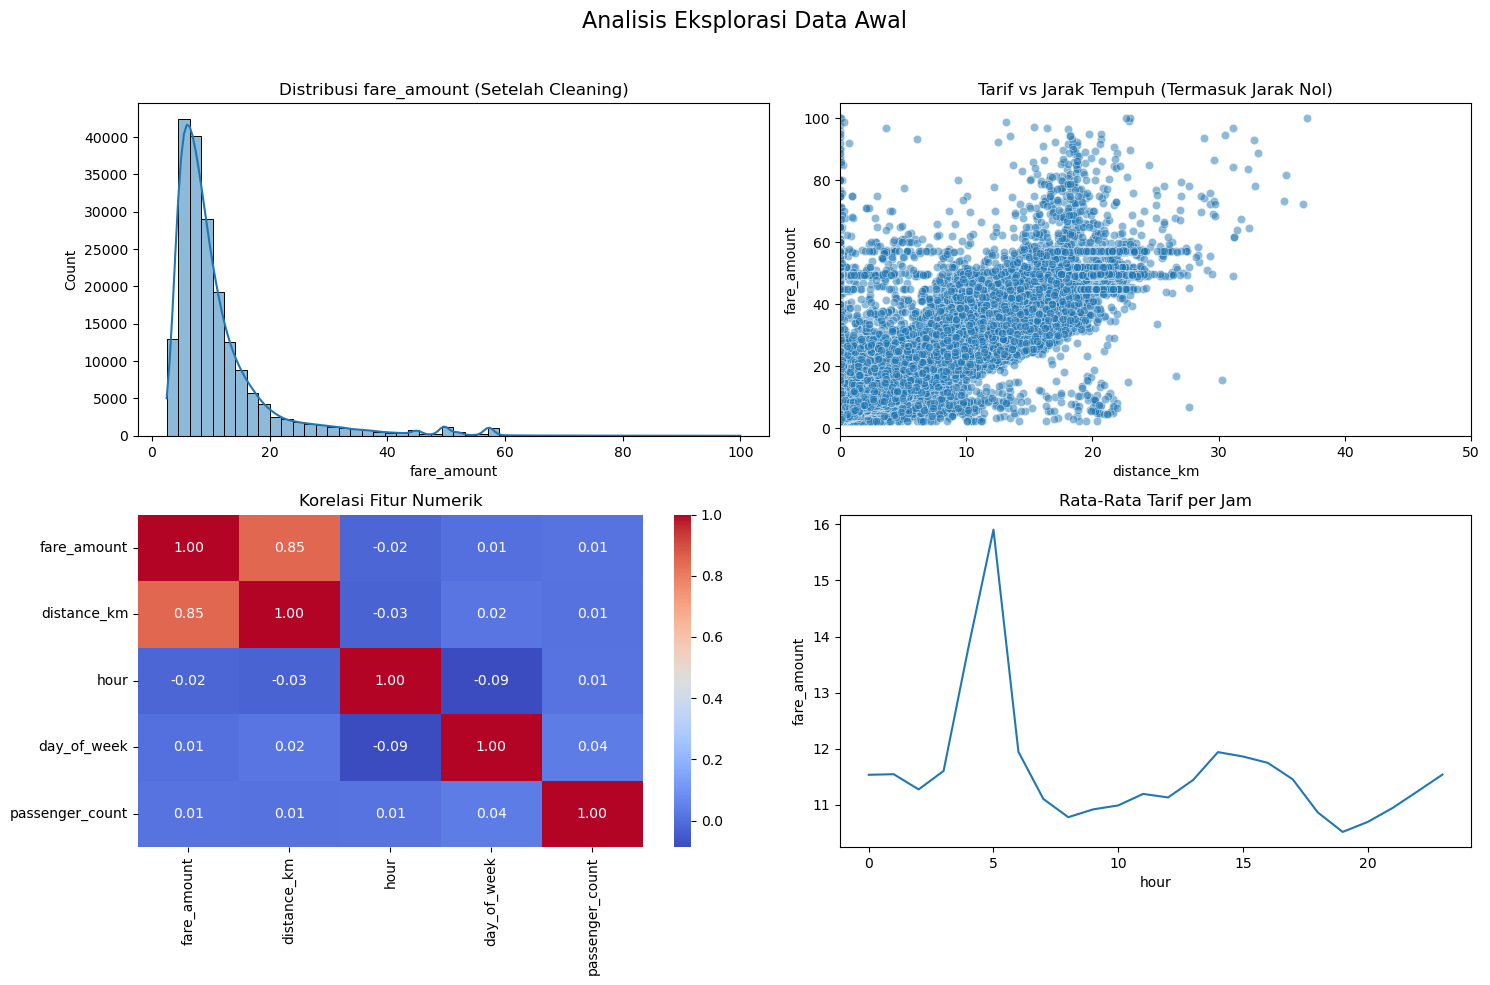


Menampilkan Grafik Tambahan untuk Analisis Lebih Dalam...


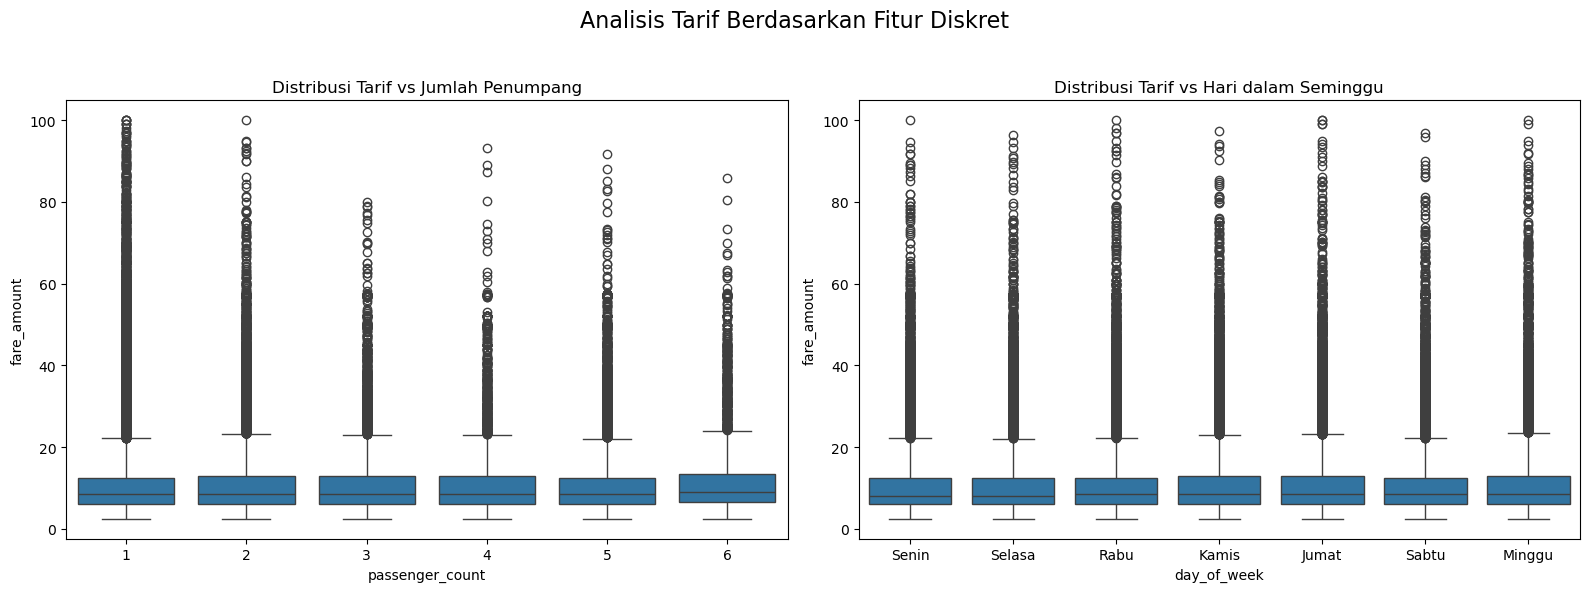


Membuat peta sebaran titik penjemputan yang lebih fokus...


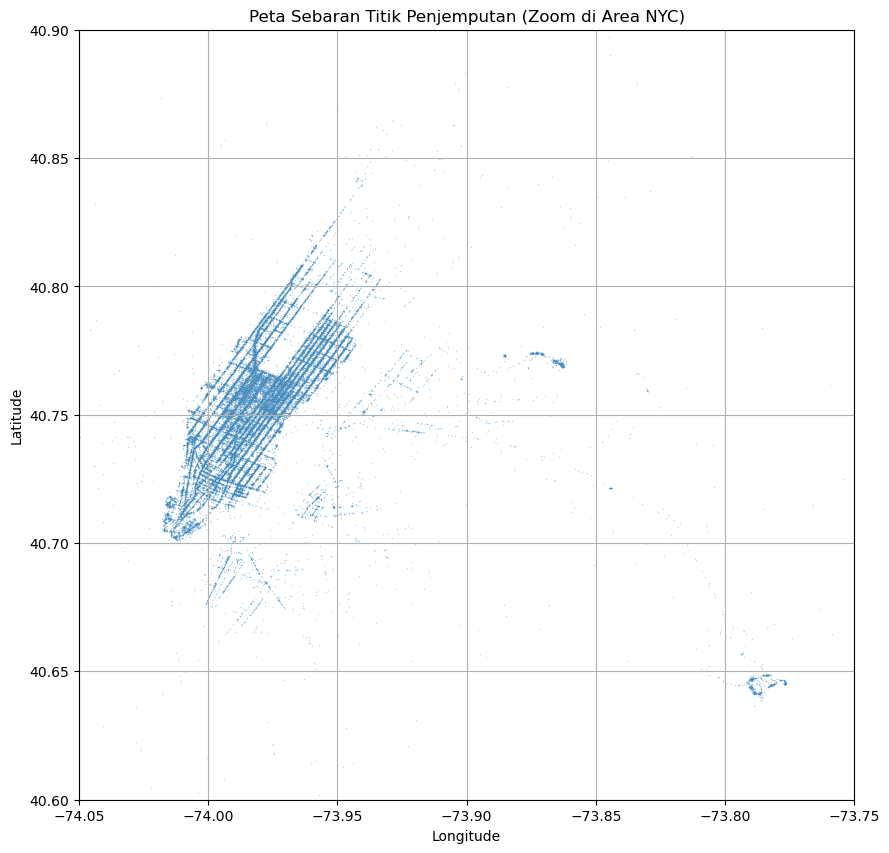

In [18]:
# Asumsi df_clean sudah tersedia dari tahap pembersihan data sebelumnya
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# ===================================================================
# Bagian 1: Visualisasi Asli Anda
# ===================================================================
print("Menampilkan 4 Grafik Visualisasi Awal...")
plt.figure(figsize=(15, 10))
plt.suptitle("Analisis Eksplorasi Data Awal", fontsize=16)

# A. Distribusi Tarif (Setelah Cleaning)
plt.subplot(2, 2, 1)
sns.histplot(df_clean['fare_amount'], bins=50, kde=True)
plt.title("Distribusi fare_amount (Setelah Cleaning)")

# B. Korelasi Jarak vs Tarif (Data Asli)
plt.subplot(2, 2, 2)
sns.scatterplot(x='distance_km', y='fare_amount', data=df_clean, alpha=0.5)
plt.title("Tarif vs Jarak Tempuh (Termasuk Jarak Nol)")
plt.xlim(0, 50) # Batasi jarak untuk visualisasi yang lebih baik

# C. Heatmap Korelasi
plt.subplot(2, 2, 3)
corr_features = ['fare_amount', 'distance_km', 'hour', 'day_of_week', 'passenger_count']
sns.heatmap(df_clean[corr_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Korelasi Fitur Numerik")

# D. Pola Waktu
plt.subplot(2, 2, 4)
sns.lineplot(x='hour', y='fare_amount', data=df_clean, errorbar=None) # errorbar=None menggantikan ci=None
plt.title("Rata-Rata Tarif per Jam")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# ===================================================================
# Bagian 2: Visualisasi Tambahan yang Disarankan
# ===================================================================
print("\nMenampilkan Grafik Tambahan untuk Analisis Lebih Dalam...")

# --- Plot 2B: Menganalisis Fitur Kategorikal/Diskret dengan Boxplot ---
plt.figure(figsize=(16, 6))
plt.suptitle("Analisis Tarif Berdasarkan Fitur Diskret", fontsize=16)

plt.subplot(1, 2, 1)
sns.boxplot(x='passenger_count', y='fare_amount', data=df_clean)
plt.title('Distribusi Tarif vs Jumlah Penumpang')

plt.subplot(1, 2, 2)
sns.boxplot(x='day_of_week', y='fare_amount', data=df_clean)
plt.title('Distribusi Tarif vs Hari dalam Seminggu')
plt.xticks(ticks=[0,1,2,3,4,5,6], labels=['Senin', 'Selasa', 'Rabu', 'Kamis', 'Jumat', 'Sabtu', 'Minggu'])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# --- Plot 2C: Visualisasi Geografis (REVISI dengan ZOOM) ---
print("\nMembuat peta sebaran titik penjemputan yang lebih fokus...")
plt.figure(figsize=(10, 10))

# Ambil sampel acak agar plot tidak terlalu padat dan lebih cepat
df_sample = df_clean.sample(n=50000, random_state=42)

sns.scatterplot(x='pickup_longitude', y='pickup_latitude', data=df_sample, s=1, alpha=0.3)
plt.title('Peta Sebaran Titik Penjemputan (Zoom di Area NYC)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)

# ---[ BAGIAN TAMBAHAN UNTUK ZOOM IN ]---
# Atur batas koordinat untuk fokus pada area utama New York City
# Ini akan memotong outlier dan membuat peta terlihat lebih besar/jelas
plt.xlim(-74.05, -73.75)
plt.ylim(40.6, 40.9)
# ---[ AKHIR BAGIAN TAMBAHAN ]---

plt.show()

Tahap 2: Preprocessing Lanjutan & Pembagian Data (Revisi Total)

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

# =============================================================================
# Tahap 3: Preprocessing Lanjutan & Pembagian Data
# =============================================================================
# 1. Pilih Fitur (X) dan Target (y)
# HAPUS 'hour' dan 'day_of_week' asli, GUNAKAN fitur siklus yang baru
features = [
    'distance_km',
    'passenger_count',
    'hour_sin', 'hour_cos', # Fitur siklus jam
    'day_sin', 'day_cos'   # Fitur siklus hari
]
target = 'fare_amount'

X = df_clean[features]
y = df_clean[target]

# 2. Bagi Data MENJADI Latih dan Uji SEBELUM SCALING
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Scaling Fitur Numerik (CARA YANG BENAR)
scaler = StandardScaler()

# FIT dan TRANSFORM pada data Latih
X_train_scaled = scaler.fit_transform(X_train)

# HANYA TRANSFORM pada data Uji
X_test_scaled = scaler.transform(X_test)

# ---> MENYIMPAN FILE PERTAMA: scaler.joblib <---
joblib.dump(scaler, 'scaler.joblib')
print("\n✅ File 'scaler.joblib' BERHASIL DISIMPAN.")

# Konversi kembali ke DataFrame agar nama kolom tidak hilang (opsional, tapi praktik yang baik)
X_train = pd.DataFrame(X_train_scaled, columns=features)
X_test = pd.DataFrame(X_test_scaled, columns=features)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")


✅ File 'scaler.joblib' BERHASIL DISIMPAN.
Training set shape: (156016, 6)
Test set shape: (39005, 6)


Tahap 3: Pelatihan dan Evaluasi Model (Revisi)

In [10]:
# Pastikan library yang relevan sudah di-import
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# Siapkan dictionary kosong untuk menyimpan hasil dan model terbaik
results = {}
fitted_models = {}

In [11]:
# ===================================================================
# 1. Pelatihan Model: Linear Regression
# ===================================================================
# Linear Regression tidak memiliki hyperparameter yang kompleks untuk dituning,
# jadi kita langsung melatihnya.

print("--- Melatih Linear Regression ---")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Prediksi dan evaluasi
y_pred_lr = lr_model.predict(X_test)
results['Linear Regression'] = {
    'MAE': mean_absolute_error(y_test, y_pred_lr),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_lr)),
    'R2': r2_score(y_test, y_pred_lr)
}
fitted_models['Linear Regression'] = lr_model
print("Linear Regression selesai dilatih.")

--- Melatih Linear Regression ---
Linear Regression selesai dilatih.


In [12]:
# ===================================================================
# 2. Tuning dan Pelatihan Model: Random Forest
# ===================================================================
print("\n--- Tuning Random Forest ---")

# Definisikan hyperparameter yang akan diuji
rf_param_grid = {
    'n_estimators': [100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

# Siapkan GridSearchCV
rf_grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=rf_param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='neg_mean_squared_error',
    n_jobs=-1, # Gunakan semua core CPU
    verbose=1
)

# Jalankan pencarian parameter terbaik
rf_grid_search.fit(X_train, y_train)

# Ambil model terbaik
best_rf_model = rf_grid_search.best_estimator_
print(f"Parameter terbaik untuk Random Forest: {rf_grid_search.best_params_}")

# Prediksi dan evaluasi dengan model terbaik
y_pred_rf = best_rf_model.predict(X_test)
results['Random Forest'] = {
    'MAE': mean_absolute_error(y_test, y_pred_rf),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_rf)),
    'R2': r2_score(y_test, y_pred_rf)
}
fitted_models['Random Forest'] = best_rf_model
print("Random Forest selesai dituning.")


--- Tuning Random Forest ---
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Parameter terbaik untuk Random Forest: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Random Forest selesai dituning.


In [13]:
# ===================================================================
# 3. Tuning dan Pelatihan Model: XGBoost
# ===================================================================
print("\n--- Tuning XGBoost ---")

# Definisikan hyperparameter yang akan diuji
xgb_param_grid = {
    'n_estimators': [100],
    'max_depth': [3, 6],
    'learning_rate': [0.1, 0.3]
}

# Siapkan GridSearchCV
xgb_grid_search = GridSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid=xgb_param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Jalankan pencarian parameter terbaik
xgb_grid_search.fit(X_train, y_train)

# Ambil model terbaik
best_xgb_model = xgb_grid_search.best_estimator_
print(f"Parameter terbaik untuk XGBoost: {xgb_grid_search.best_params_}")

# Prediksi dan evaluasi dengan model terbaik
y_pred_xgb = best_xgb_model.predict(X_test)
results['XGBoost'] = {
    'MAE': mean_absolute_error(y_test, y_pred_xgb),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_xgb)),
    'R2': r2_score(y_test, y_pred_xgb)
}
fitted_models['XGBoost'] = best_xgb_model
print("XGBoost selesai dituning.")


--- Tuning XGBoost ---
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Parameter terbaik untuk XGBoost: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 100}
XGBoost selesai dituning.


In [14]:
# ===================================================================
# 4. Gabungkan Hasil, Tampilkan, dan Simpan Model Terbaik
# ===================================================================
metrics_df = pd.DataFrame(results).T
print("\n=============== PERBANDINGAN PERFORMA MODEL (DENGAN FITUR SIKLUS) ===============")
print(metrics_df.round(3))
print("=================================================================================")


=============== PERBANDINGAN PERFORMA MODEL (DENGAN FITUR SIKLUS) ===============
                     MAE   RMSE     R2
Linear Regression  2.418  4.959  0.727
Random Forest      2.255  4.247  0.800
XGBoost            2.264  4.306  0.794


In [15]:
# Simpan model terbaik (berdasarkan hasil R2 tertinggi)
best_model_name = metrics_df['R2'].idxmax()
best_model_final = fitted_models[best_model_name]

joblib.dump(best_model_final, 'model_terbaik_final.joblib')
print(f"\nModel terbaik ({best_model_name}) telah disimpan ke file 'model_terbaik_final.joblib'")


Model terbaik (Random Forest) telah disimpan ke file 'model_terbaik_final.joblib'


In [16]:
import pandas as pd
import numpy as np
import joblib

# ===================================================================
# Anggap Anda sudah menyimpan model dan scaler dari tahap latihan
# ===================================================================

# Muat kembali model dan scaler yang sudah disimpan
try:
    final_model = joblib.load('model_terbaik_final.joblib')
    scaler = joblib.load('scaler.joblib') # Anda perlu menyimpan scaler ini juga!
    print("Model dan scaler berhasil dimuat.")
except FileNotFoundError:
    print("File model/scaler tidak ditemukan. Pastikan Anda sudah melatih dan menyimpannya.")
    # Inisialisasi dummy agar kode tidak error saat dijalankan pertama kali
    final_model, scaler = None, None

# ===================================================================
# Fungsi untuk melakukan prediksi pada satu input baru
# ===================================================================

def predict_fare(pickup_datetime_str, distance_km, passenger_count, model, scaler):
    """
    Fungsi untuk memprediksi tarif Uber berdasarkan input pengguna.

    Args:
        pickup_datetime_str (str): Waktu penjemputan dalam format string (e.g., "2025-08-09 10:30:00").
        distance_km (float): Jarak perjalanan dalam km.
        passenger_count (int): Jumlah penumpang.
        model: Objek model machine learning yang sudah dilatih.
        scaler: Objek StandardScaler yang sudah di-fit pada data latih.

    Returns:
        float: Hasil prediksi tarif.
    """
    if not model or not scaler:
        return "Model/scaler belum tersedia."

    # --- Langkah 1: Ubah Input Waktu menjadi Fitur Siklus ---
    # Konversi string ke objek datetime
    pickup_time = pd.to_datetime(pickup_datetime_str)
    
    # Ekstrak jam dan hari
    hour = pickup_time.hour
    day_of_week = pickup_time.dayofweek

    # Hitung fitur siklus
    hour_sin = np.sin(2 * np.pi * hour / 24.0)
    hour_cos = np.cos(2 * np.pi * hour / 24.0)
    day_sin = np.sin(2 * np.pi * day_of_week / 7.0)
    day_cos = np.cos(2 * np.pi * day_of_week / 7.0)

    # --- Langkah 2: Siapkan Data Input untuk Model ---
    # Buat DataFrame dari input dengan urutan kolom yang BENAR
    features_dict = {
        'distance_km': [distance_km],
        'passenger_count': [passenger_count],
        'hour_sin': [hour_sin],
        'hour_cos': [hour_cos],
        'day_sin': [day_sin],
        'day_cos': [day_cos]
    }
    input_df = pd.DataFrame(features_dict)

    # --- Langkah 3: Lakukan Scaling ---
    input_scaled = scaler.transform(input_df)

    # --- Langkah 4: Lakukan Prediksi ---
    prediction = model.predict(input_scaled)

    # Hasil prediksi adalah array, ambil nilai pertamanya
    return prediction[0]

# ===================================================================
# Contoh Penggunaan Fungsi Prediksi
# ===================================================================

# Input dari pengguna
waktu_jemput = "2025-08-09 10:30:00" # Sabtu pagi
jarak_tempuh = 5.5
jumlah_penumpang = 2

# Panggil fungsi untuk mendapatkan prediksi
prediksi_tarif = predict_fare(waktu_jemput, jarak_tempuh, jumlah_penumpang, final_model, scaler)

# Tampilkan hasil
if isinstance(prediksi_tarif, str):
    print(prediksi_tarif)
else:
    print(f"\n--- HASIL PREDIKSI ---")
    print(f"Waktu: {waktu_jemput}")
    print(f"Jarak: {jarak_tempuh} km")
    print(f"Penumpang: {jumlah_penumpang}")
    print(f"Prediksi Tarif: ${prediksi_tarif:.2f}")

Model dan scaler berhasil dimuat.

--- HASIL PREDIKSI ---
Waktu: 2025-08-09 10:30:00
Jarak: 5.5 km
Penumpang: 2
Prediksi Tarif: $15.10


c:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
